# Calibration

### Data Processing

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [13]:
df = pd.read_csv('/home/ragitha/Desktop/Data.csv')

In [14]:
df_clean = df.dropna()

In [15]:
df_clean.columns = df.columns.str.replace(' ', '_').str.lower()
df_clean.columns = df.columns.str.replace(') ', '_').str.lower()
df_clean.columns = df.columns.str.replace('(', '_').str.lower()

In [16]:
df_clean

,real temp_c),tem,thermistor resistor_down_ohms),termistor resistor_up_ohms),average_r
0,25,298.15,9902.12,9823.39,9862.755
1,26,299.15,9560.32,9501.89,9531.100
2,27,300.15,9265.54,9597.80,9431.670
3,28,301.15,8909.43,9085.27,8997.350
4,29,302.15,8532.61,8186.34,8359.480
...,...,...,...,...,...
65,90,363.15,848.36,817.80,833.080
67,92,365.15,791.14,760.64,775.890
69,94,367.15,734.52,746.89,740.700
71,96,369.15,678.50,676.54,677.520


### Training Model

In [17]:
x_data = df_clean['average_r'].values
y_data = df_clean['tem'].values

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error

X = X_train.reshape(-1, 1)

# --- 2. Find the "Best Fit" Polynomial ---
degrees_to_test = [1, 2, 3, 4, 5]
n = len(y_train)
print("--- Finding Best Polynomial Fit ---")

for degree in degrees_to_test:
    # Create polynomial features
    poly_features = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly_features.fit_transform(X)
    
    # Fit the model
    model = LinearRegression()
    model.fit(X_poly, y_train)
    
    # Make predictions
    y_pred = model.predict(X_poly)
    
    # Calculate metrics 
    r2 = r2_score(y_train, y_pred)
    rmse = np.sqrt(mean_squared_error(y_train, y_pred))
    
    # Calculate Adjusted R²
    k = degree
    adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - k - 1))
    
    print(f"\n--- Degree {degree} ---")
    print(f"R-squared: {r2:.6f}")
    print(f"Adj. R-squared: {adj_r2:.6f}")
    print(f"RMSE: {rmse:.6f} (degrees C)")
    
    # Print the equation
    coeffs = model.coef_
    intercept = model.intercept_
    equation = f"T(x) = {intercept:.8f}"
    for i in range(degree):
        equation += f" + ({coeffs[i]:.8f})*x^{i+1}"
    print(equation)

--- Finding Best Polynomial Fit ---

--- Degree 1 ---
R-squared: 0.866081
Adj. R-squared: 0.863291
RMSE: 7.140052 (degrees C)
T(x) = 356.65946094 + (-0.00734255)*x^1

--- Degree 2 ---
R-squared: 0.977744
Adj. R-squared: 0.976797
RMSE: 2.910764 (degrees C)
T(x) = 371.99354834 + (-0.01728456)*x^1 + (0.00000106)*x^2

--- Degree 3 ---
R-squared: 0.993665
Adj. R-squared: 0.993251
RMSE: 1.552996 (degrees C)
T(x) = 381.81163696 + (-0.02769273)*x^1 + (0.00000371)*x^2 + (-0.00000000)*x^3

--- Degree 4 ---
R-squared: 0.996922
Adj. R-squared: 0.996648
RMSE: 1.082458 (degrees C)
T(x) = 389.69542156 + (-0.03917372)*x^1 + (0.00000852)*x^2 + (-0.00000000)*x^3 + (0.00000000)*x^4

--- Degree 5 ---
R-squared: 0.986257
Adj. R-squared: 0.984695
RMSE: 2.287277 (degrees C)
T(x) = 366.47664190 + (-0.00000001)*x^1 + (-0.00001280)*x^2 + (0.00000000)*x^3 + (-0.00000000)*x^4 + (0.00000000)*x^5


[-3.91737248e-02  8.51663403e-06 -9.22326268e-10  3.74291760e-14]


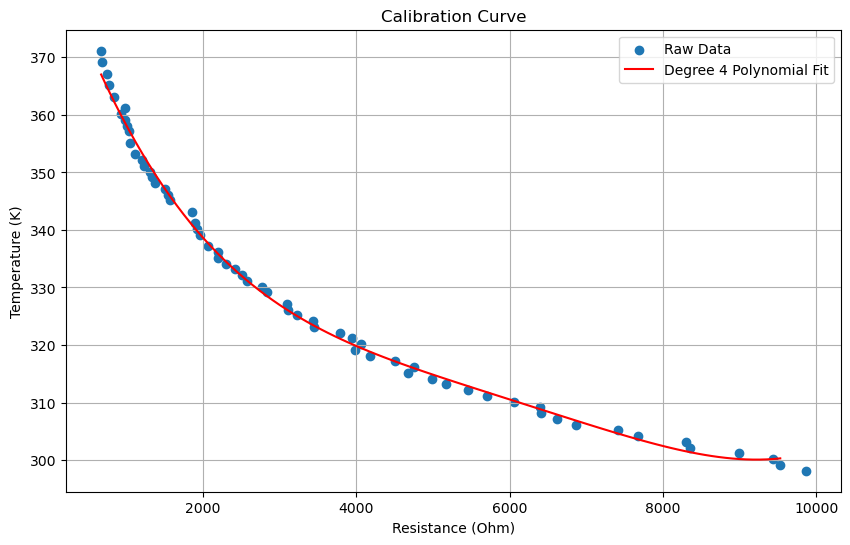

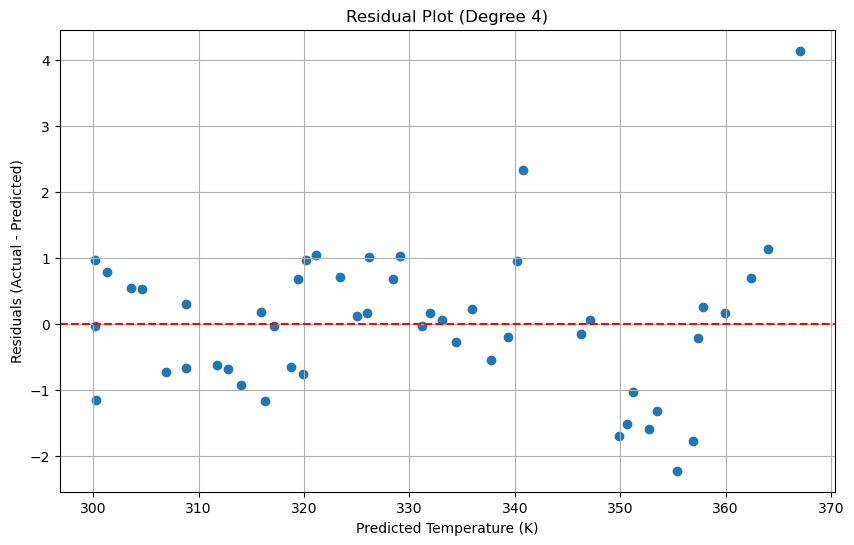

In [19]:
chosen_degree = 4
poly_features = PolynomialFeatures(degree=chosen_degree, include_bias=False)
X_poly = poly_features.fit_transform(X)

model = LinearRegression()
model.fit(X_poly, y_train)
print(model.coef_)
y_pred = model.predict(X_poly)


X_fit = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
X_fit_poly = poly_features.transform(X_fit)
y_fit = model.predict(X_fit_poly)


plt.figure(figsize=(10, 6))
plt.scatter(x_data, y_data, label='Raw Data')
plt.plot(X_fit, y_fit, color='red', label=f'Degree {chosen_degree} Polynomial Fit')
plt.xlabel('Resistance (Ohm)')
plt.ylabel('Temperature (K)')
plt.title('Calibration Curve')
plt.legend()
plt.grid(True)
plt.show()

 
residuals = y_train - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Temperature (K)')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title(f'Residual Plot (Degree {chosen_degree})')
plt.grid(True)
plt.show()

### Testing the Trained Model

In [20]:
X = X_test.reshape(-1, 1)
chosen_degree = 4
poly_features = PolynomialFeatures(degree=chosen_degree, include_bias=False)
X_poly = poly_features.fit_transform(X)


y_pred = model.predict(X_poly)
    
    # Calculate metrics 
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Calculate Adjusted R²

print(f"R-squared: {r2:.6f}")
print(f"Adj. R-squared: {adj_r2:.6f}")
print(f"RMSE: {rmse:.6f} (degrees C)")
    
   

R-squared: 0.996081
Adj. R-squared: 0.984695
RMSE: 1.543127 (degrees C)


### Train Model with Full Data 

390.70216731534543
[-3.97489713e-02  8.51830664e-06 -8.97928113e-10  3.52922387e-14]


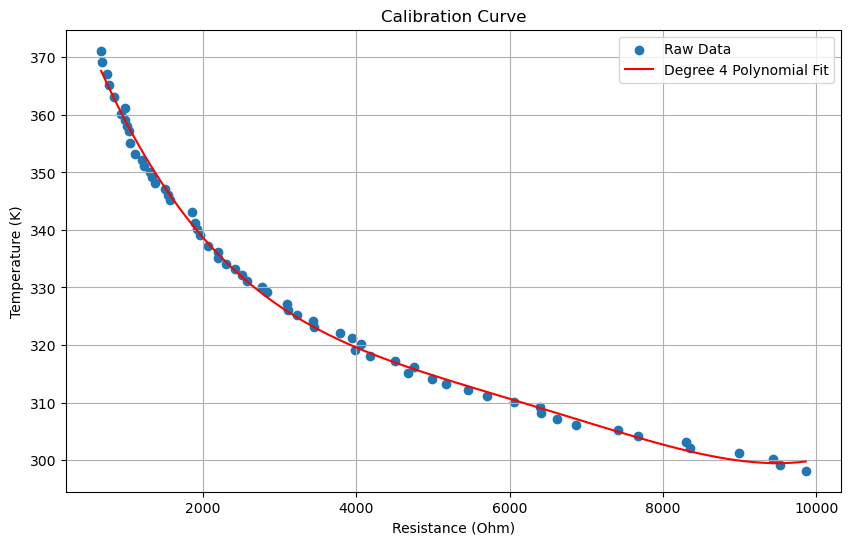

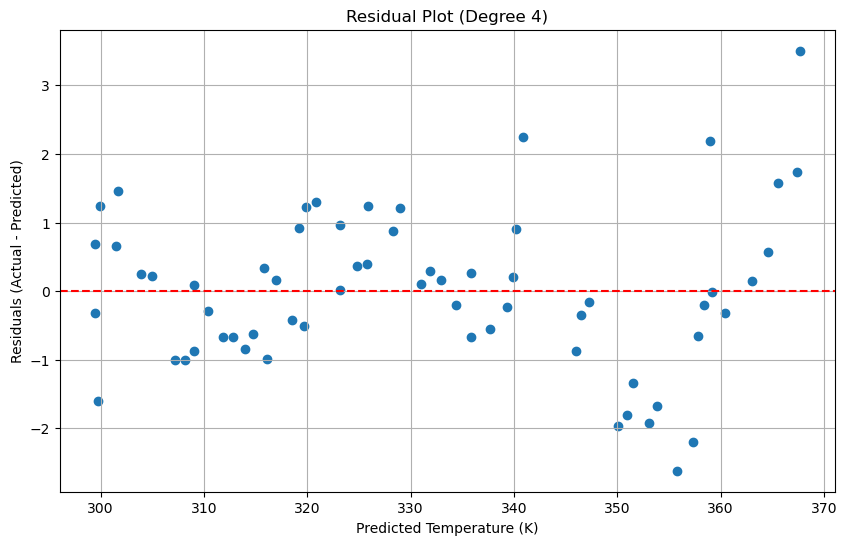

In [21]:
chosen_degree = 4
X = x_data.reshape(-1, 1)
poly_features = PolynomialFeatures(degree=chosen_degree, include_bias=False)
X_poly = poly_features.fit_transform(X)

model = LinearRegression()
model.fit(X_poly, y_data)
print(model.intercept_)
print(model.coef_)
y_pred = model.predict(X_poly)


X_fit = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
X_fit_poly = poly_features.transform(X_fit)
y_fit = model.predict(X_fit_poly)


plt.figure(figsize=(10, 6))
plt.scatter(x_data, y_data, label='Raw Data')
plt.plot(X_fit, y_fit, color='red', label=f'Degree {chosen_degree} Polynomial Fit')
plt.xlabel('Resistance (Ohm)')
plt.ylabel('Temperature (K)')
plt.title('Calibration Curve')
plt.legend()
plt.grid(True)
plt.show()

 
residuals = y_data - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Temperature (K)')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title(f'Residual Plot (Degree {chosen_degree})')
plt.grid(True)
plt.show()

In [22]:
def Tem_prediction(x_data):
    y_pred = 390.70216731534543 + (-3.97489713e-02)*x_data + (8.51830664e-06)*(x_data**2) + (-8.97928113e-10)*(x_data**3) + (3.52922387e-14)*(x_data**4)
    return y_pred
    

In [23]:
y_pred = Tem_prediction(x_data)
r2 = r2_score(y_data, y_pred)
rmse = np.sqrt(mean_squared_error(y_data, y_pred))
    
    # Calculate Adjusted R²

print(f"R-squared: {r2:.6f}")
print(f"Adj. R-squared: {adj_r2:.6f}")
print(f"RMSE: {rmse:.6f} (degrees C)")

R-squared: 0.996986
Adj. R-squared: 0.984695
RMSE: 1.136610 (degrees C)


In [24]:
Tem_prediction(6100)

310.25208400031715

# Time constant calculate

------------------------------
CALIBRATION RESULTS
------------------------------
Calculated Time Constant (tau): 6.2208 seconds
Initial Voltage: 3.7898 V
Final Voltage:   0.4890 V
------------------------------


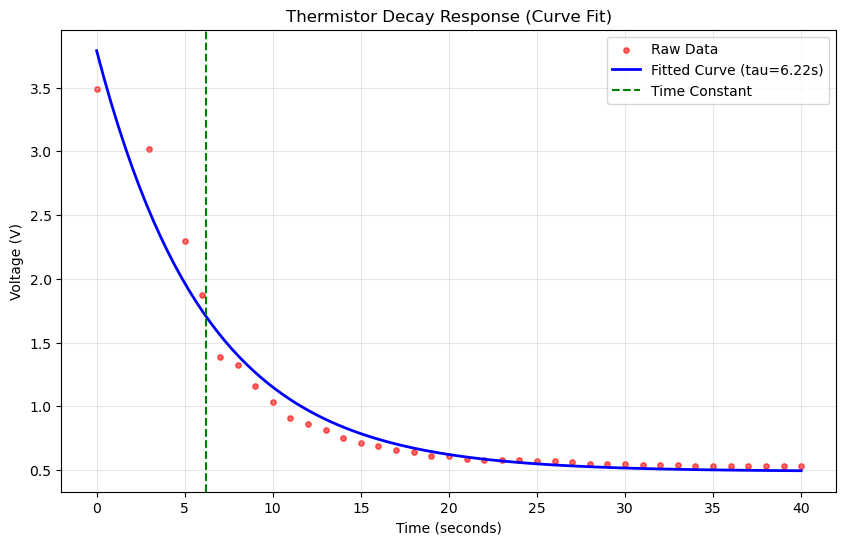

In [25]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# ==========================================
# 1. Load Your Data
# ==========================================
# Replace 'transient_data.csv' with your actual file name
# Ensure columns are named 'Time' and 'Voltage'
df = pd.read_excel('/home/ragitha/Desktop/data_t.xlsx')
t_data = df['time'].values
v_data = df['voltage'].values


# ==========================================
# 2. Define the Decay Model
# ==========================================
# Formula: V(t) = V_final + (V_initial - V_final) * e^(-t / tau)
def decay_model(t, v_final, v_initial, tau):
    return v_final + (v_initial - v_final) * np.exp(-t / tau)

# ==========================================
# 3. Fit the Curve
# ==========================================
# We need to give the computer reasonable starting guesses
# Guess v_final is the last point, v_initial is the first point, tau is approx 5s
initial_guesses = [v_data[-1], v_data[0], 5.0]

try:
    # Perform the curve fit
    popt, pcov = curve_fit(decay_model, t_data, v_data, p0=initial_guesses)
    
    # Extract the calculated values
    v_final_calc, v_initial_calc, tau_calc = popt
    
    print("-" * 30)
    print(f"CALIBRATION RESULTS")
    print("-" * 30)
    print(f"Calculated Time Constant (tau): {tau_calc:.4f} seconds")
    print(f"Initial Voltage: {v_initial_calc:.4f} V")
    print(f"Final Voltage:   {v_final_calc:.4f} V")
    print("-" * 30)

    # ==========================================
    # 4. Plotting
    # ==========================================
    # Generate smooth line for the fit
    t_fit = np.linspace(min(t_data), max(t_data), 100)
    v_fit = decay_model(t_fit, *popt)

    plt.figure(figsize=(10, 6))
    
    # Plot Raw Data
    plt.scatter(t_data, v_data, color='red', label='Raw Data', s=15, alpha=0.6)
    
    # Plot Fitted Curve
    plt.plot(t_fit, v_fit, color='blue', linewidth=2, label=f'Fitted Curve (tau={tau_calc:.2f}s)')

    # Mark the Time Constant location on the graph
    # For decay, tau is where voltage drops to ~36.8% of the step
    plt.axvline(x=tau_calc, color='green', linestyle='--', label='Time Constant')
    
    plt.xlabel('Time (seconds)')
    plt.ylabel('Voltage (V)')
    plt.title('Thermistor Decay Response (Curve Fit)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Save the plot if needed
    # plt.savefig('calibration_curve.png')
    plt.show()

except Exception as e:
    print(f"Error calculating fit: {e}")
    print("Check if your data contains NaN values or if the CSV path is correct.")